In [1]:
from _element import feature_control as ft_c

In [2]:
from _usecase import algorithm_prophet as prpt

In [3]:
from _element import calculations as calc

In [4]:
import pandas as pd

In [5]:
from datetime import datetime

In [6]:
from _element import varr

In [7]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withobject.xlsx'

In [8]:
df_raw= ft_c.xlsx_opener(varr.PJ_DIR+varr.DF_DIR, INPUT_FILENAME)

In [9]:
df_temp= ft_c.xlsx_opener(varr.PJ_DIR+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [10]:
y_col= df_raw.columns.values.tolist()

In [11]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [12]:
y_col

[1041, 1692, 1815, 1853, 1878]

In [13]:
x_col= df_temp.columns.values.tolist()

In [14]:
x_col

['ds', 'temp_max', 'temp_min', 'rain_amount']

In [15]:
df_raw['ds']= pd.to_datetime(df_raw['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [16]:
df_temp['ds']= pd.to_datetime(df_temp['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [17]:
df_raw= pd.merge(df_raw, df_temp, how='inner', on='ds')

In [18]:
df_raw.head()

,ds,1041,1692,1815,1853,1878,temp_max,temp_min,rain_amount
0,2010-07-01,5698,9534,44580,5328,4003,30.500000,24.900000,0.0
1,2010-07-02,2740,7910,44920,6644,5629,25.799999,22.700001,70.0
2,2010-07-03,2742,4176,26213,5111,2706,25.600000,22.600000,1.0
3,2010-07-04,0,0,299,746,0,29.700001,23.100000,0.0
4,2010-07-05,3451,4844,39234,5927,2700,30.600000,21.799999,0.0


In [19]:
df_weekday_0= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==0]
df_weekday_1= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==1]
df_weekday_2= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==2]
df_weekday_3= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==3]
df_weekday_4= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==4]
df_weekday_5= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==5]
df_weekday_6= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==6]

In [20]:
result_dict= {}
for y in y_col:
    result_dict[y]= {
                    'mon': prpt.Bayseian2(df_weekday_0, varr.FORECASTDAY, y, x_col, 'week'),\
                    'tue': prpt.Bayseian2(df_weekday_1, varr.FORECASTDAY, y, x_col, 'week'),\
                    'wed': prpt.Bayseian2(df_weekday_2, varr.FORECASTDAY, y, x_col, 'week'),\
                    'thu': prpt.Bayseian2(df_weekday_3, varr.FORECASTDAY, y, x_col, 'week'),\
                    'pri': prpt.Bayseian2(df_weekday_4, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sat': prpt.Bayseian2(df_weekday_5, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sun': prpt.Bayseian2(df_weekday_6, varr.FORECASTDAY, y, x_col, 'week'),\
                    }

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_

In [21]:
merged_dict={}
for y in y_col:
    merged_dict[y]={'future': 
                    pd.concat([result_dict[y]['mon']['future'],\
                              result_dict[y]['tue']['future'],\
                              result_dict[y]['wed']['future'],\
                              result_dict[y]['thu']['future'],\
                              result_dict[y]['pri']['future'],\
                              result_dict[y]['sat']['future'],\
                              result_dict[y]['sun']['future']],\
                              axis= 0).sort_values(by='ds', axis=0),
                   'forecastProphetTable':
                    pd.concat([result_dict[y]['mon']['forecastProphetTable'],\
                              result_dict[y]['tue']['forecastProphetTable'],\
                              result_dict[y]['wed']['forecastProphetTable'],\
                              result_dict[y]['thu']['forecastProphetTable'],\
                              result_dict[y]['pri']['forecastProphetTable'],\
                              result_dict[y]['sat']['forecastProphetTable'],\
                              result_dict[y]['sun']['forecastProphetTable']],\
                              axis= 0).sort_values(by='ds', axis=0)
                   }

In [28]:
forecast_dict={}
print(INPUT_FILENAME)
for y in y_col:
    merged_dict[y]['future']['ds']= pd.to_datetime(merged_dict[y]['future']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    merged_dict[y]['forecastProphetTable']['ds']= pd.to_datetime(merged_dict[y]['forecastProphetTable']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    forecast_dict[y]= prpt.extract_info_from(merged_dict[y]['future'], merged_dict[y]['forecastProphetTable'], varr.FORECASTDAY)
    forecast_dict[y]['result_df']= pd.merge(forecast_dict[y]['result_df'], df_raw[['ds', y]], how='inner', on='ds')
    print('RMSE with segment '+str(y)+': '+str(calc.rms_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE with segment '+str(y)+': '+str(calc.map_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_with_std with segment '+str(y)+': '+str(calc.map_error_with_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_div_std with segment '+str(y)+': '+str(calc.map_error_div_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('sMAPE of company code '+str(y)+': '+str(calc.smap_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print(forecast_dict[y]['result_df'].head())
    ft_c.save_as_xlsx(varr.PJ_DIR+varr.DF_DIR, forecast_dict[y]['result_df'], INPUT_FILENAME, '_seg'+str(y)+'withweekday')
    print('\n')

KPP일별투입(10_17)_withobject.xlsx
RMSE with segment 1041: 1700.92122951
MAPE with segment 1041: inf
MAPE_with_std with segment 1041: 40.5716652071
MAPE_div_std with segment 1041: 104.339950823
sMAPE of company code 1041: 12.9645534218
          ds   temp_max  temp_min  rain_amount         yhat  1041
0 2017-11-01  17.299999      13.4          0.0  5252.519289  8615
1 2017-11-02  18.000000      14.0          1.6  6058.602081  6794
2 2017-11-03  15.700000       4.5          0.6  5476.709864  6946
3 2017-11-04  12.800000       3.2          0.0  4545.476992  4092
4 2017-11-05  14.200000       7.3          0.0     6.242562     0


c:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100




RMSE with segment 1692: 1629.92150392
MAPE with segment 1692: inf
MAPE_with_std with segment 1692: 22.070100784
MAPE_div_std with segment 1692: 72.7477335519
sMAPE of company code 1692: 4.10725408136
          ds   temp_max  temp_min  rain_amount          yhat   1692
0 2017-11-01  17.299999      13.4          0.0  18674.248380  19275
1 2017-11-02  18.000000      14.0          1.6  17986.289103  19673
2 2017-11-03  15.700000       4.5          0.6  17817.789453  19659
3 2017-11-04  12.800000       3.2          0.0   9127.702824   8193
4 2017-11-05  14.200000       7.3          0.0     16.059404      0


RMSE with segment 1815: 4033.8044423
MAPE with segment 1815: 12.0857556682
MAPE_with_std with segment 1815: 17.2062889949
MAPE_div_std with segment 1815: 87.3319159984
sMAPE of company code 1815: 2.60023095412
          ds   temp_max  temp_min  rain_amount          yhat   1815
0 2017-11-01  17.299999      13.4          0.0  81186.639705  75861
1 2017-11-02  18.000000      14.0         

In [29]:
y_col

[1041, 1692, 1815, 1853, 1878]

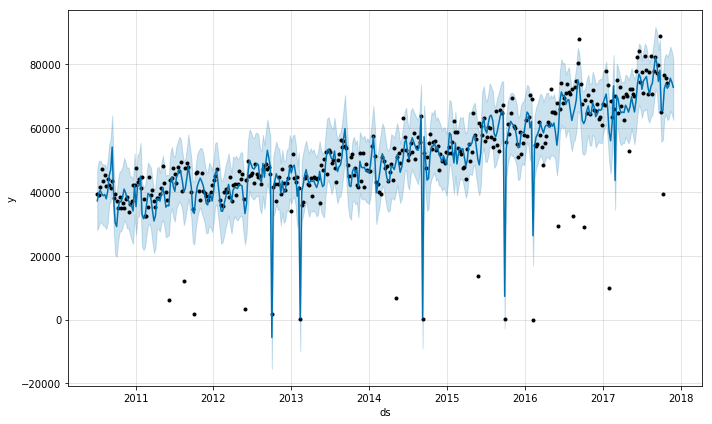

In [30]:
result_dict[1815]['mon']['model'].plot(result_dict[1815]['mon']['forecastProphetTable'])

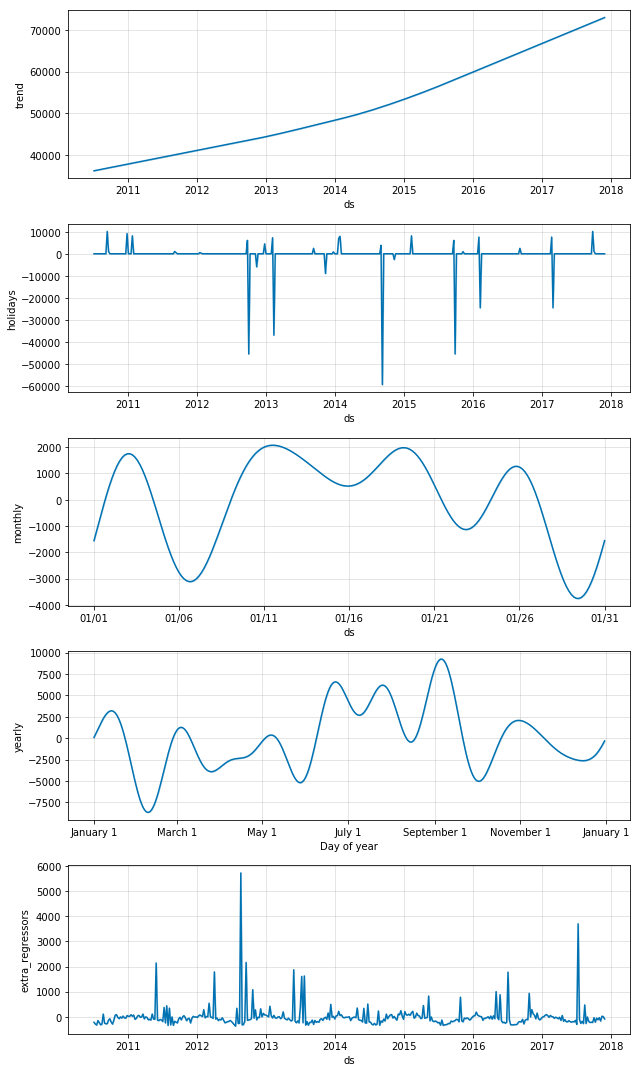

In [31]:
result_dict[1815]['mon']['model'].plot_components(result_dict[1815]['mon']['forecastProphetTable'])

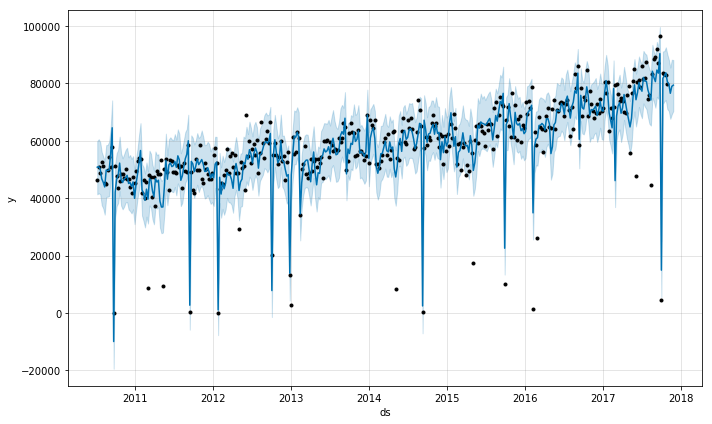

In [32]:
result_dict[1815]['tue']['model'].plot(result_dict[1815]['tue']['forecastProphetTable'])

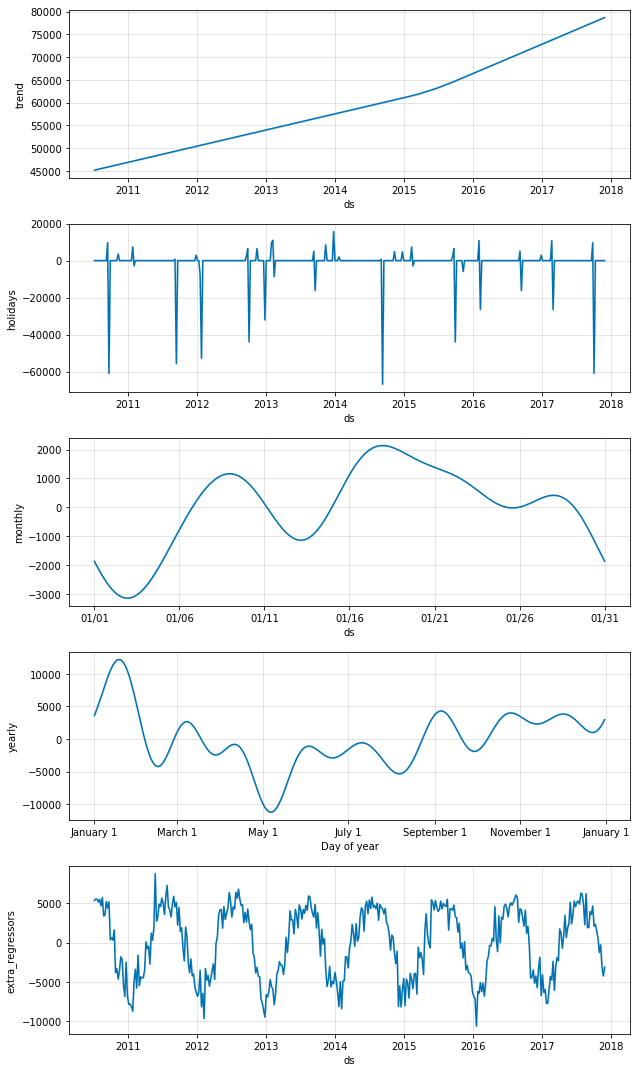

In [33]:
result_dict[1815]['tue']['model'].plot_components(result_dict[1815]['tue']['forecastProphetTable'])

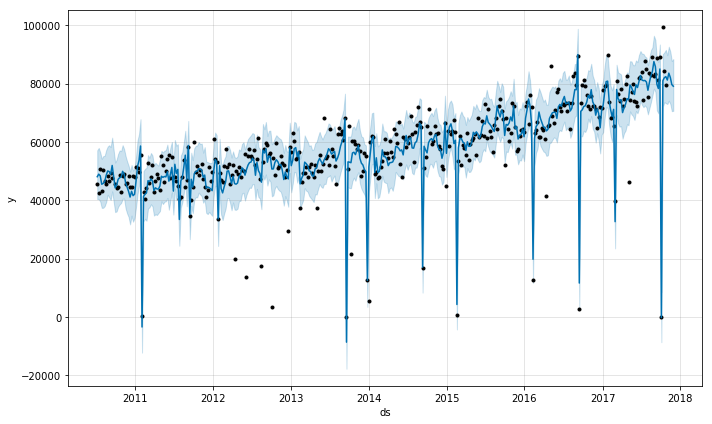

In [34]:
result_dict[1815]['wed']['model'].plot(result_dict[1815]['wed']['forecastProphetTable'])

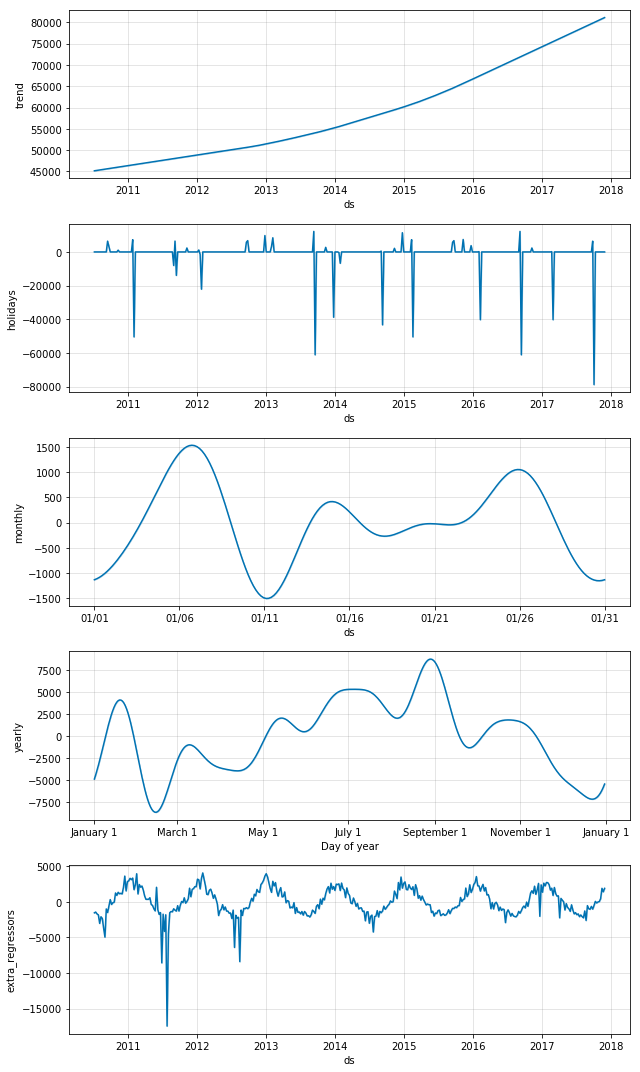

In [35]:
result_dict[1815]['wed']['model'].plot_components(result_dict[1815]['wed']['forecastProphetTable'])

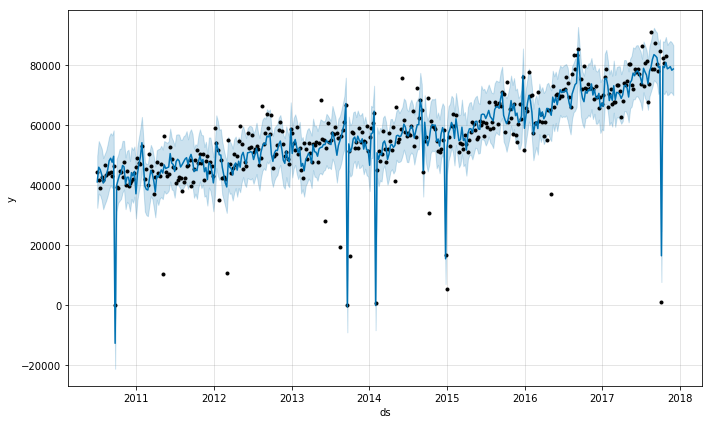

In [36]:
result_dict[1815]['thu']['model'].plot(result_dict[1815]['thu']['forecastProphetTable'])

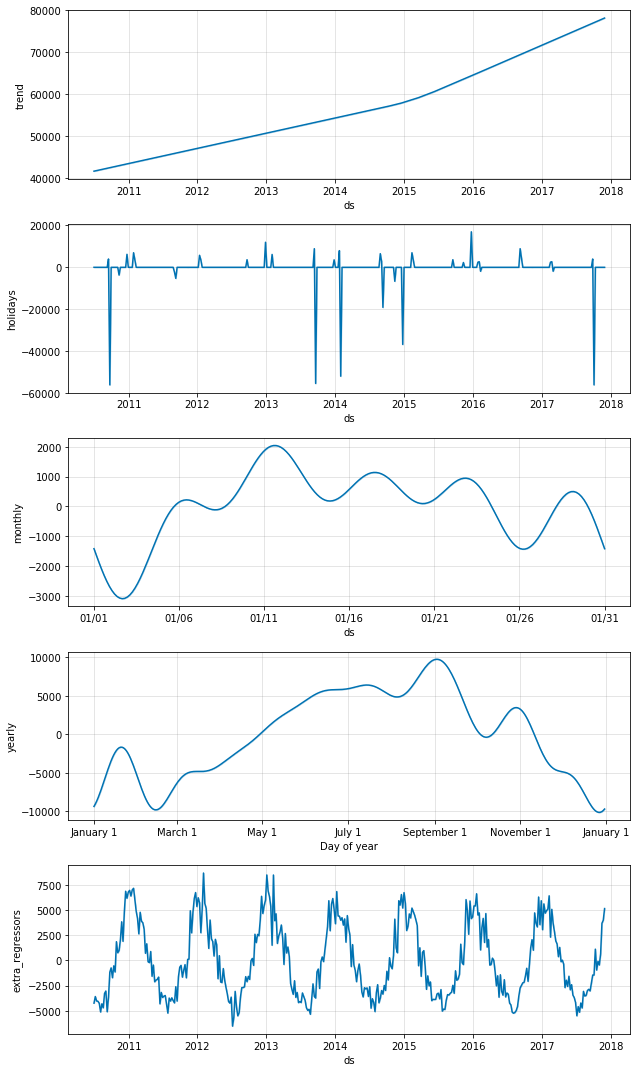

In [37]:
result_dict[1815]['thu']['model'].plot_components(result_dict[1815]['thu']['forecastProphetTable'])

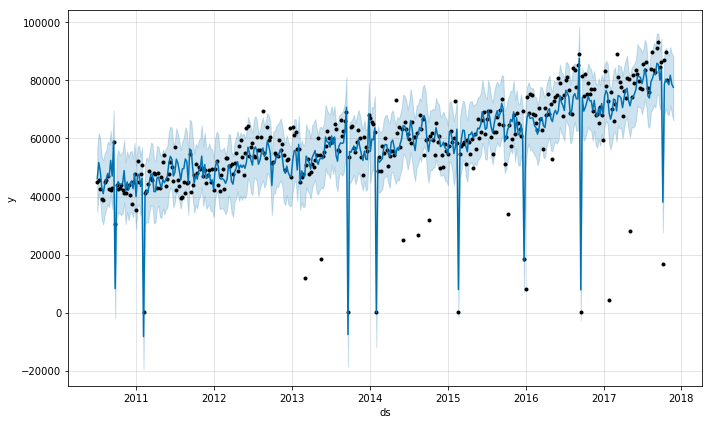

In [38]:
result_dict[1815]['pri']['model'].plot(result_dict[1815]['pri']['forecastProphetTable'])

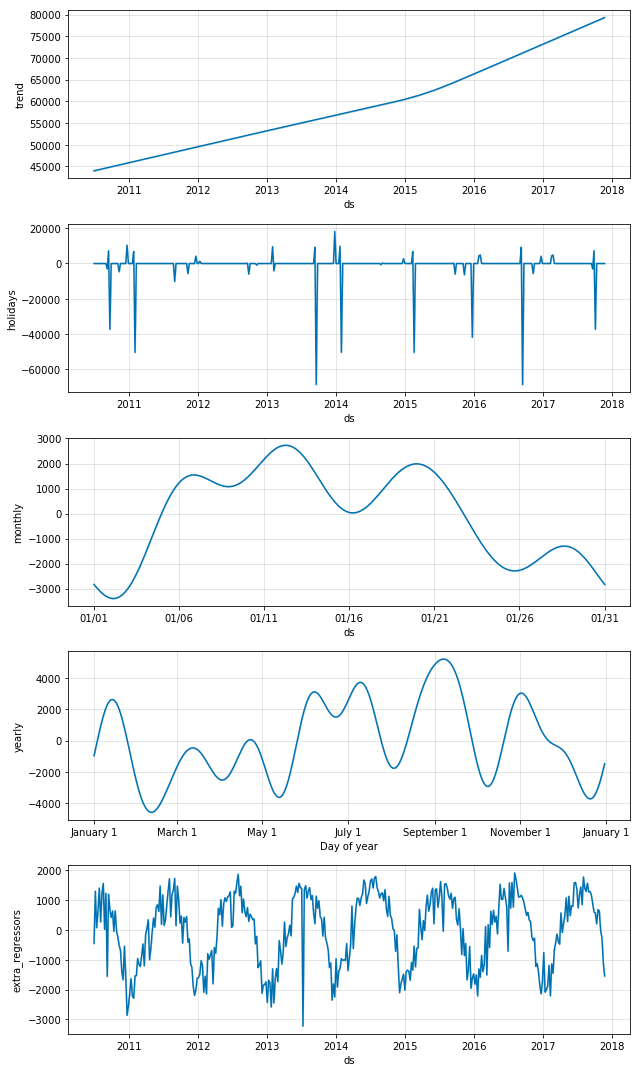

In [39]:
result_dict[1815]['pri']['model'].plot_components(result_dict[1815]['pri']['forecastProphetTable'])

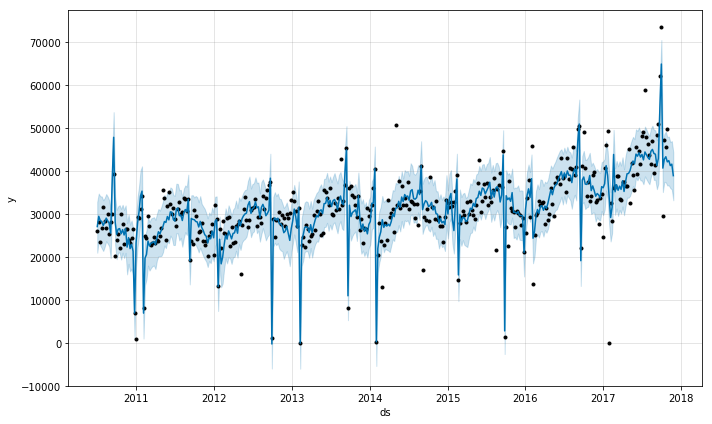

In [40]:
result_dict[1815]['sat']['model'].plot(result_dict[1815]['sat']['forecastProphetTable'])

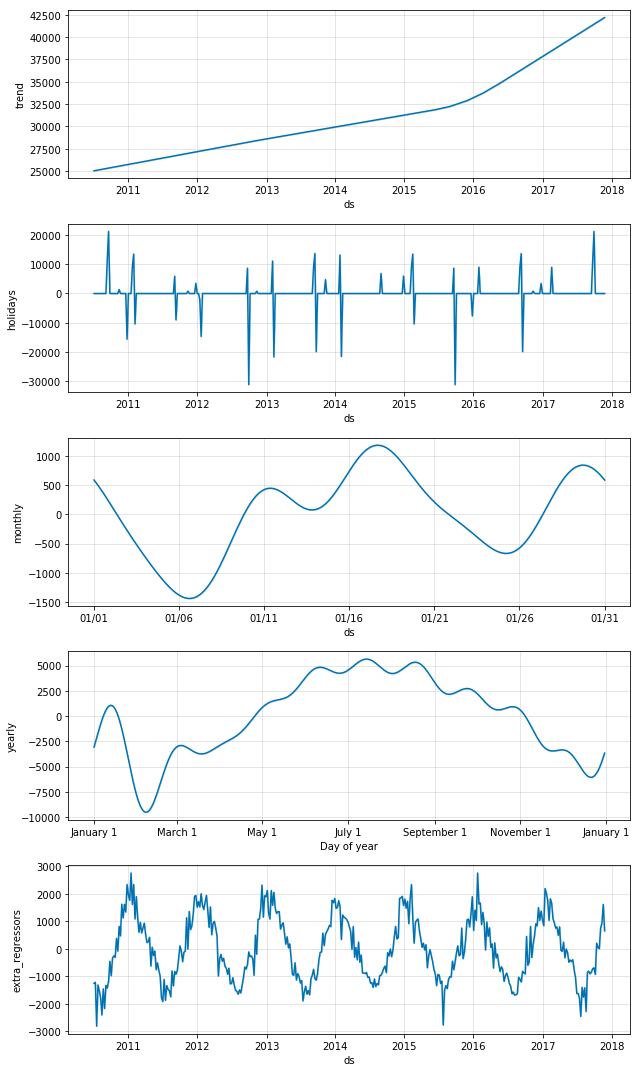

In [41]:
result_dict[1815]['sat']['model'].plot_components(result_dict[1815]['sat']['forecastProphetTable'])

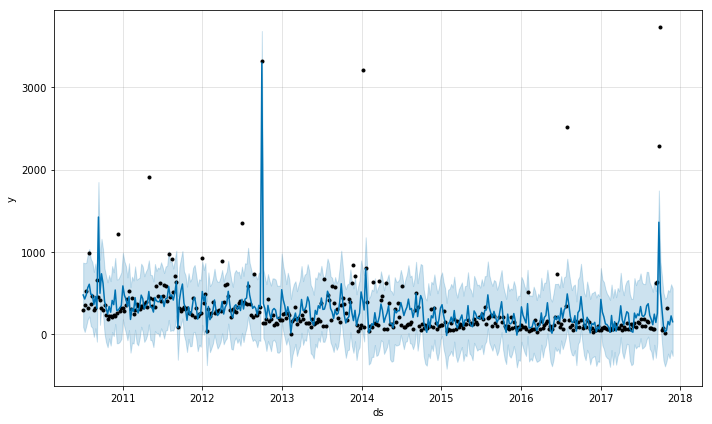

In [42]:
result_dict[1815]['sun']['model'].plot(result_dict[1815]['sun']['forecastProphetTable'])

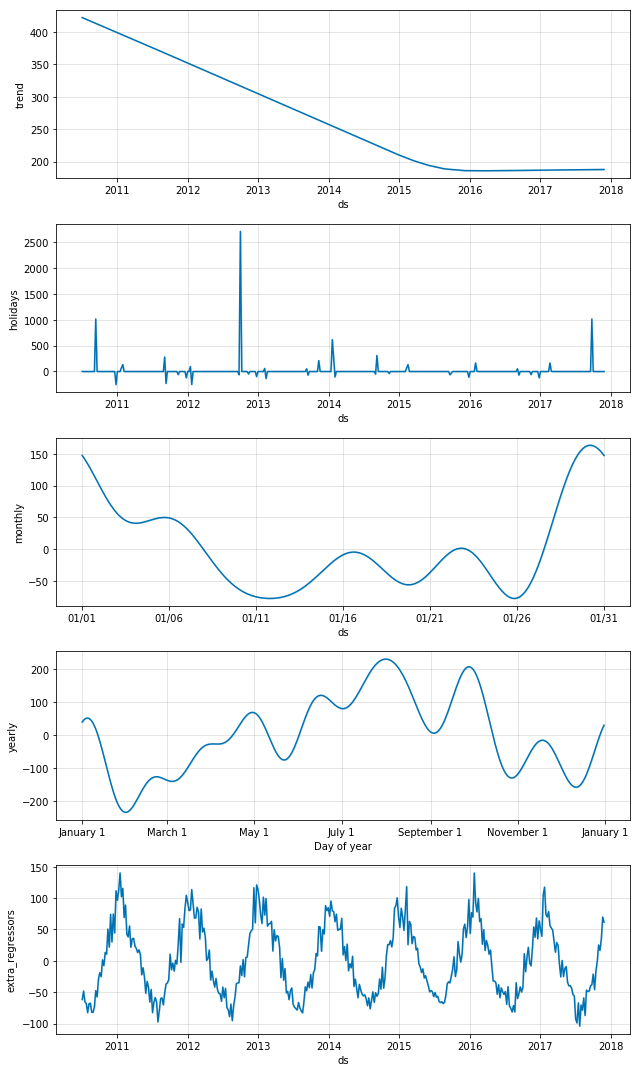

In [43]:
result_dict[1815]['sun']['model'].plot_components(result_dict[1815]['sun']['forecastProphetTable'])